In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim,utils,torch

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
class autoencoder(nn.Module):
    input_size = 784
    hidden_sizes = [128, 32]
    output_size = 2
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.output_size))
        self.decoder = nn.Sequential(nn.Linear(self.output_size, self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.input_size),
                      nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
vanila_ae = autoencoder()
print(vanila_ae)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)


In [7]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = vanila_ae(images) #log probabilities

criterion = nn.MSELoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,images) #calculate the loss


In [8]:
print('Before backward pass: \n', vanila_ae.encoder[0].weight.grad)
loss.backward()
print('After backward pass: \n', vanila_ae.encoder[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-4.4070e-06, -4.4070e-06, -4.4070e-06,  ..., -4.4070e-06,
         -4.4070e-06, -4.4070e-06],
        [ 3.9938e-05,  3.9938e-05,  3.9938e-05,  ...,  3.9938e-05,
          3.9938e-05,  3.9938e-05],
        [ 1.5543e-06,  1.5543e-06,  1.5543e-06,  ...,  1.5543e-06,
          1.5543e-06,  1.5543e-06],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.4425e-06, -1.4425e-06, -1.4425e-06,  ..., -1.4425e-06,
         -1.4425e-06, -1.4425e-06],
        [ 1.4849e-05,  1.4849e-05,  1.4849e-05,  ...,  1.4849e-05,
          1.4849e-05,  1.4849e-05]])


Epoch 0 - Training loss: 0.2032550347766388
Epoch 1 - Training loss: 0.1750469696578949
Epoch 2 - Training loss: 0.16916278441514032
Epoch 3 - Training loss: 0.1655482914783299
Epoch 4 - Training loss: 0.163709669971644

Training Time (in minutes) = 1.2456420143445333


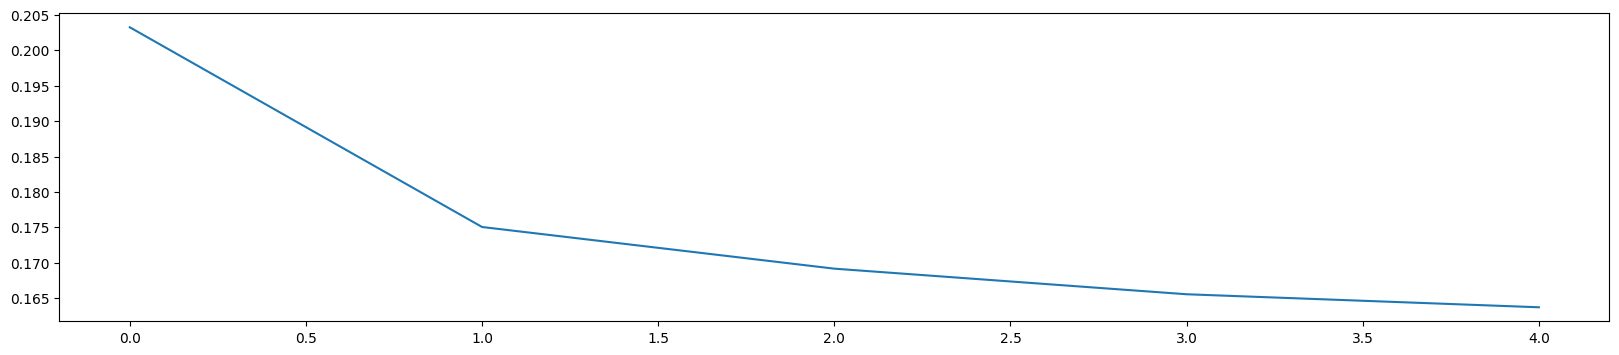

In [9]:
optimizer = optim.Adam(vanila_ae.parameters(), lr=0.003, weight_decay=1e-5)
time0 = time()
epochs = 5
loss_hist = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        
        output = vanila_ae(images)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_hist.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)
plt.figure(figsize=(20, 4))
plt.plot(loss_hist)
plt.show()

c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


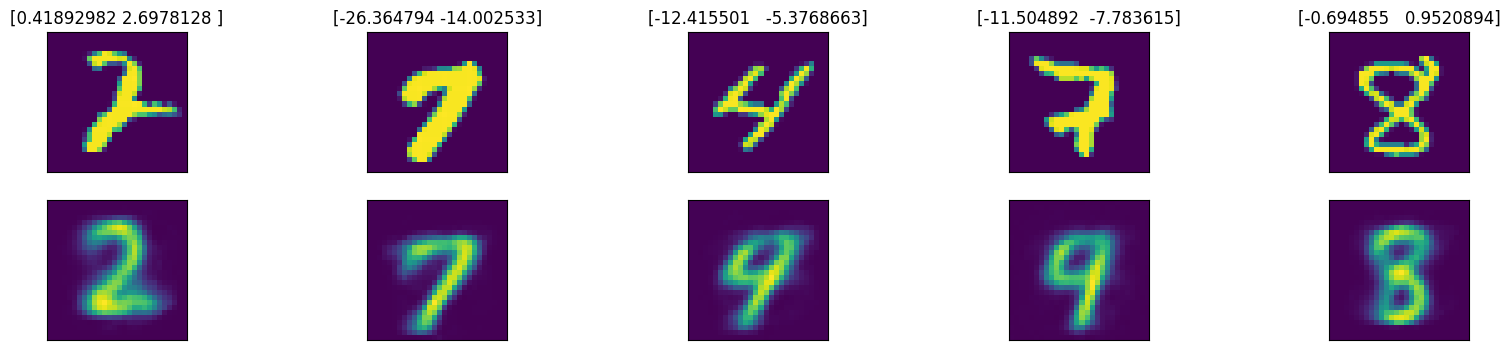

In [10]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    encoded = vanila_ae.encoder(images.view(-1, 784))
    decoded = vanila_ae.decoder(encoded)

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(encoded[i].numpy())
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
encoded = torch.tensor([])
labels = torch.tensor([])
test_images = torch.tensor([])

for imgs, lbls in valloader:
        imgs = imgs.view(imgs.shape[0], -1)
        en = vanila_ae.encoder(imgs)
        encoded=torch.cat((encoded,en))
        labels=torch.cat((labels,lbls))
        test_images=torch.cat((test_images,imgs))

print(encoded.shape)
print(labels.shape)

torch.Size([10000, 2])
torch.Size([10000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


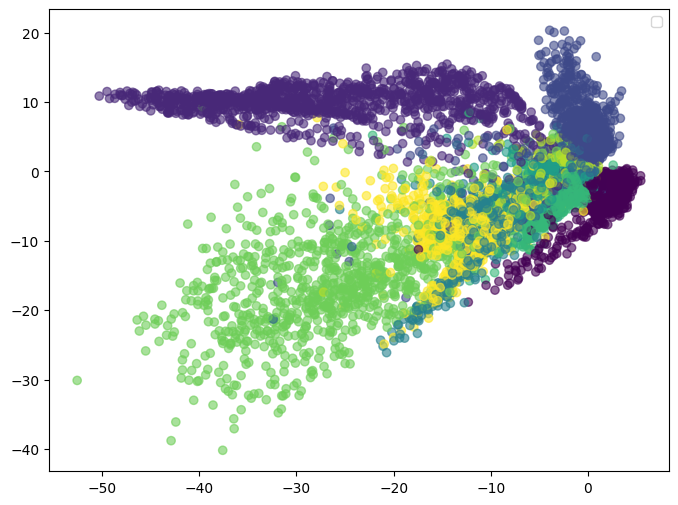

In [20]:

plt.figure(figsize=(8, 6))
with torch.no_grad():
        plt.scatter(encoded[:,0],encoded[:,1], c=labels, alpha = 0.6,marker='o')
plt.legend()
plt.show()

In [35]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

## Function to Scale and visualize the embedding vectors
def plot_embedding(X,y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure(figsize=(12,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 20e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(test_images[i].reshape(28,28), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


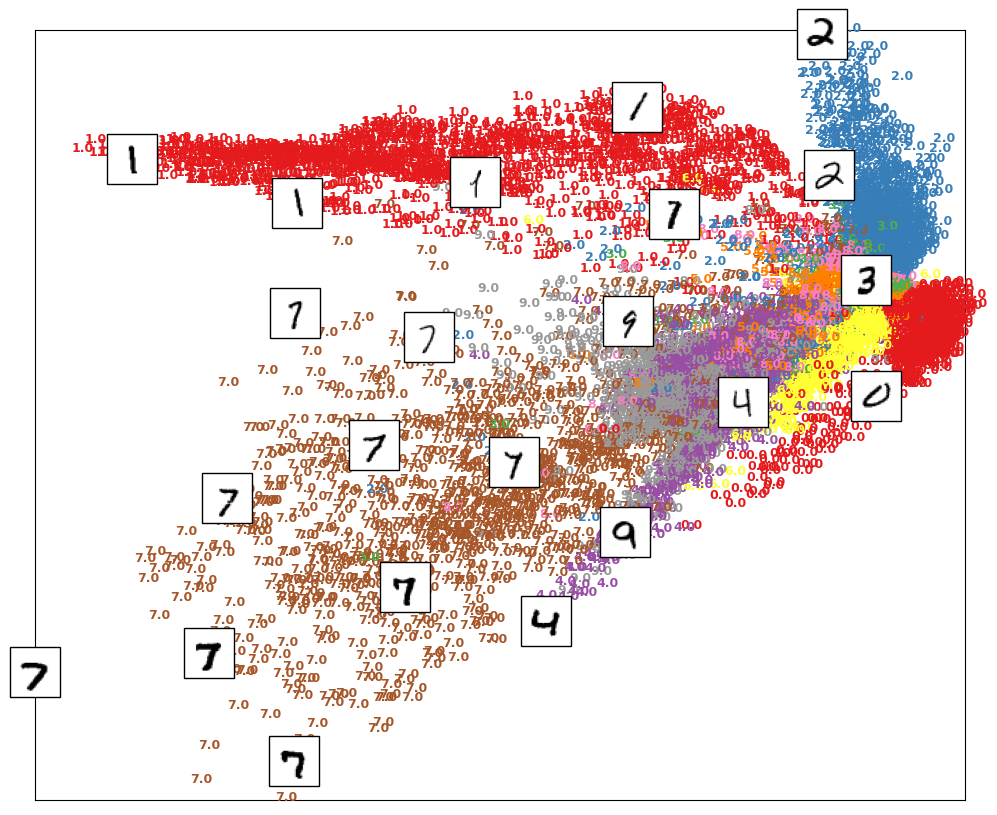

In [36]:
with torch.no_grad():
    plot_embedding(encoded.numpy(),labels.numpy())

In [ ]:
noise_factor = 0.7
x_train_noisy = images + noise_factor * torch.randn(*images.shape)
x_train_noisy = np.clip(x_train_noisy, -1., 1.)
print(images[0][0][14])
print(x_train_noisy[0][0][14])

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9686, -0.2627,  0.9843,  0.9843,  0.9843,  1.0000,  0.9843,
         0.9765, -0.3725, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000])
tensor([-1.0000, -0.6370, -0.4299, -1.0000, -1.0000, -0.7061,  0.9963, -0.1111,
        -0.2662, -0.3376,  0.4075,  0.5117,  0.5513,  1.0000,  1.0000,  0.8929,
         0.5036, -1.0000, -1.0000, -1.0000, -0.4705, -0.6304, -0.3485, -1.0000,
        -1.0000, -0.7728, -0.5607, -0.8571])


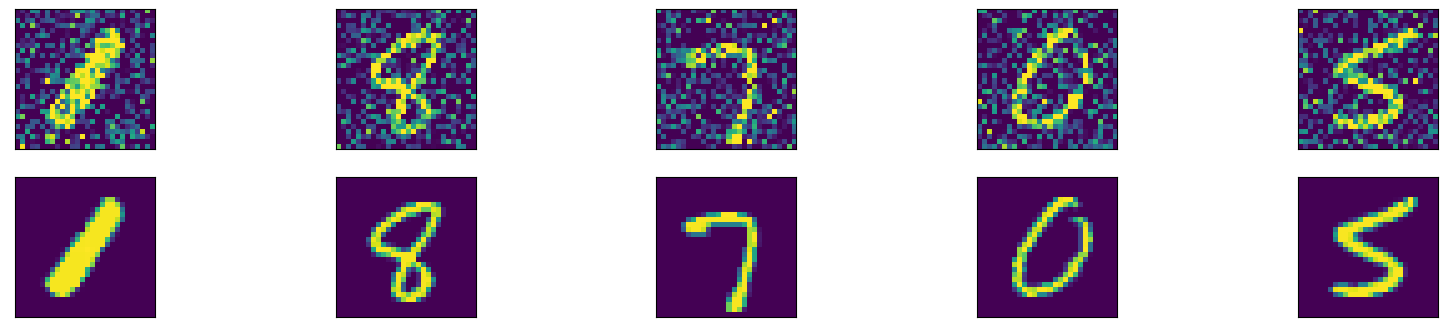

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
denoising_ae = autoencoder()
optimizer = optim.Adam(denoising_ae.parameters(), lr=0.003, weight_decay=1e-5)
time0 = time()
epochs = 5
loss_hist = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        x_train_noisy = images + noise_factor * torch.randn(*images.shape)
        x_train_noisy = np.clip(x_train_noisy, -1., 1.)
        # Training pass
        
        output = denoising_ae(x_train_noisy)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_hist.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)
plt.figure(figsize=(20, 4))
plt.plot(loss_hist)
plt.show()

Epoch 0 - Training loss: 0.20264883326696181
Epoch 1 - Training loss: 0.17752946233317288
Epoch 2 - Training loss: 0.17211887146681865
Epoch 3 - Training loss: 0.16940162462720484
Epoch 4 - Training loss: 0.1676572461340473
Epoch 5 - Training loss: 0.16614493919905823
Epoch 6 - Training loss: 0.16546295869197927
Epoch 7 - Training loss: 0.16397542261810444
Epoch 8 - Training loss: 0.16343966436220894
Epoch 9 - Training loss: 0.16314155586175064

Training Time (in minutes) = 3.325202190876007


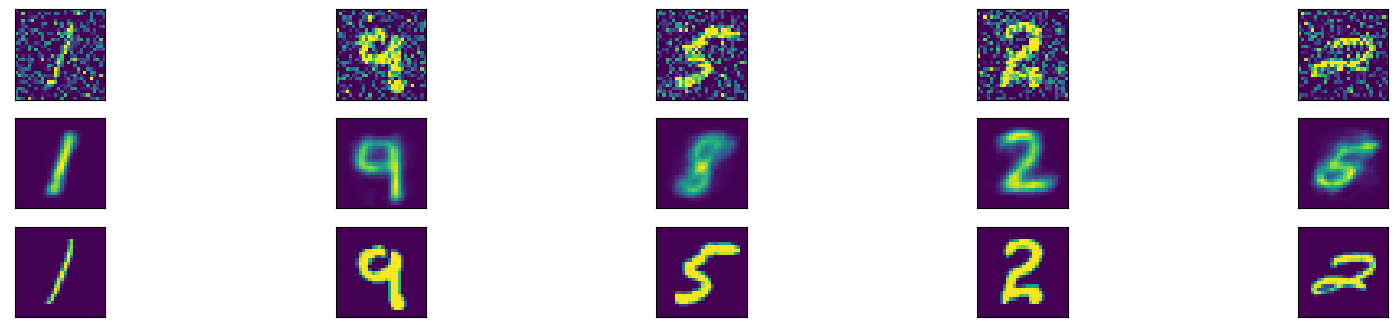

In [ ]:
images, labels = next(iter(valloader))

x_train_noisy = images + noise_factor * torch.randn(*images.shape)
x_train_noisy = np.clip(x_train_noisy, -1., 1.)
with torch.no_grad():
    denoised_images = denoising_ae(x_train_noisy.view(-1, 784))

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(denoised_images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 10)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()